In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cvx_portfolio.costs import TcostModel
from cvx_portfolio.returns import MarketReturns, AlphaSource
from cvx_portfolio.simulator import MarketSimulator
from cvx_portfolio.policies import SinglePeriodOpt, Hold
from cvx_portfolio.data import generate_alpha_signal
from cvx_portfolio.risks import EmpSigma
from cvx_portfolio.constraints import LeverageLimit  


plotdir = '../portfolio/plots/'
datadir= '../equity_data_tool/'

## Download data using ee103 code (to be integrated) 

In [2]:
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])
prices=pd.read_csv(datadir+'prices.txt',index_col=0,parse_dates=[0])

In [3]:
np.random.seed(0)
alpha_signal=generate_alpha_signal(real_returns=returns, IC=0.01, type_noise='OU')

## Market simulator 

In [4]:
spread = pd.DataFrame(data=5e-4, index=returns.index, columns=returns.columns)
nonlin_coeff = pd.DataFrame(data=1, index=returns.index, columns=returns.columns)

simulated_tcost = TcostModel(volumes, sigmas, spread, nonlin_coeff, cash_key='USDOLLAR')

simulator = MarketSimulator(MarketReturns(returns), volumes, [simulated_tcost], cash_key='USDOLLAR')

alpha_model = AlphaSource(0.0001 * alpha_signal)

risk_model = EmpSigma(returns, lookback=250)

## Portfolio

In [5]:
p = pd.Series(index=returns.columns, data=1)/len(returns.columns)
weights=p/sum(p)
p_0 = 1E10*p

## Policy

In [6]:
policy=SinglePeriodOpt(alpha_model, [.0001*risk_model, .3*simulated_tcost], 
                       [LeverageLimit(3)])

## Simulations

In [24]:
used_dates=returns.index[returns.index>='2014-01-01']
res=simulator.run_backtest(p_0, used_dates, policy=policy)

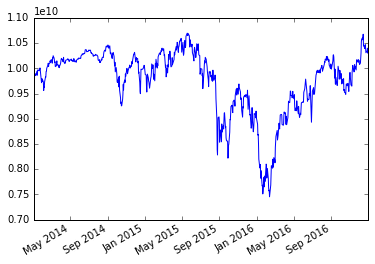

In [25]:
res.v.plot()

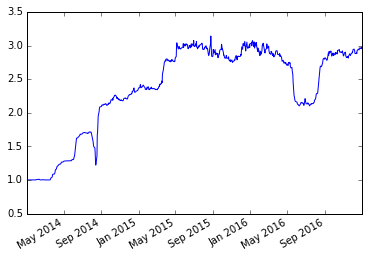

In [26]:
res.leverage.plot()

In [27]:
res.sharpe_ratio

0.14393771337893099

In [28]:
policy.costs[0].gamma, policy.costs[1].gamma

(0.0001, 0.3)

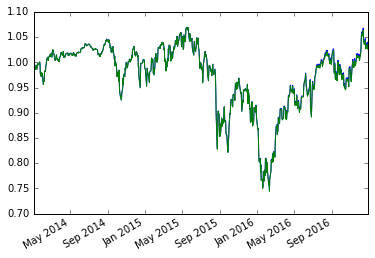

In [29]:
(1+res.returns).cumprod().plot()
(1+res.excess_returns).cumprod().plot()

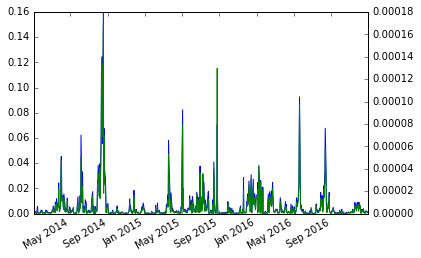

In [30]:
res.turnover.plot()
res.policy_TcostModel.sum(1).plot(secondary_y=True)

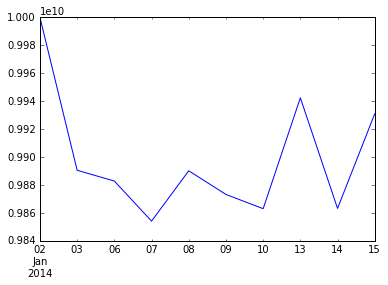

In [31]:
res.v.head(10).plot()

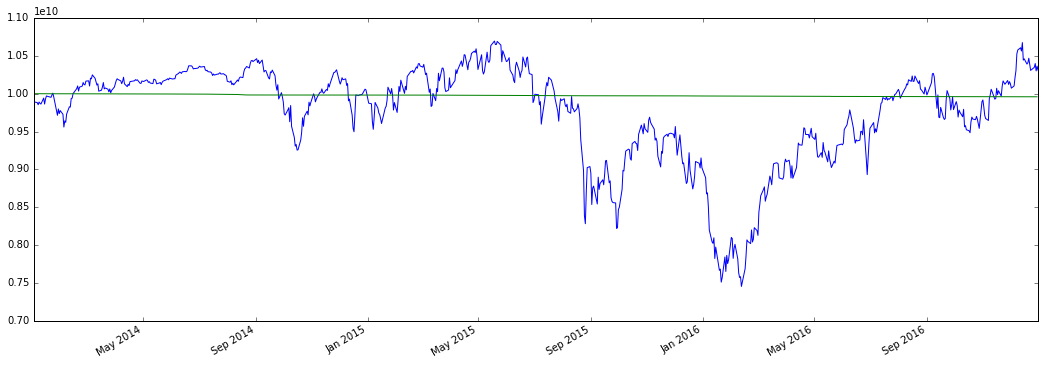

In [32]:
plt.figure(figsize=(18,6))
res.v.plot()
(res.initial_val-res.simulator_TcostModel.sum(1).cumsum()).plot()

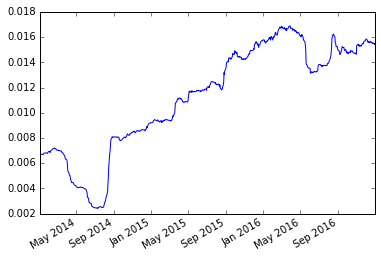

In [33]:
np.sqrt(res.policy_EmpSigma).plot()

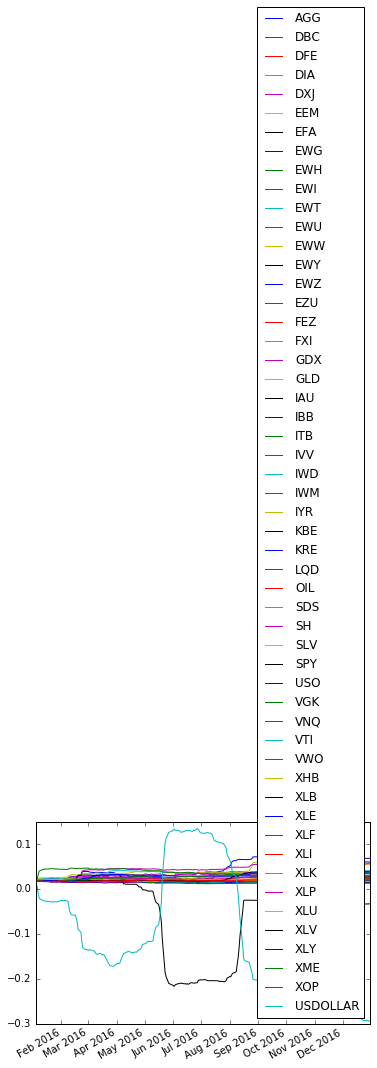

In [22]:
res.w.plot()

## Results 

In [ ]:
# pandl = lambda res: 100*(res.v[-1]-res.initial_val)/res.initial_val
# tcosts = lambda res: 100*res._data['simulation.TcostModel'].sum().sum()/res.initial_val
# tmp=pd.Panel({'P&L':res.applymap(pandl), 'TCosts':res.applymap(tcosts)})
# result_df = tmp.swapaxes(0,1).swapaxes(1,2).to_frame().T
# result_df

In [ ]:
# print(result_df.to_latex(float_format='%.2f%%'))

# Plots 

In [ ]:
# offsetx = .12
# offsety = .13

# for ticker, values in result_df.iterrows():
#     for size, coord in values.unstack().iterrows():
#         x,y=coord['TCosts'],coord['P&L']
#         if size=='$100M':
#             line1,=plt.plot(x,y, 'ko', markersize=11, fillstyle='none', label='100M fund')
#             plt.text(x-offsetx,y-offsety, ticker)

#         if size=='$10B':
#             line2,=plt.plot(x,y, 'ro', markersize=13, fillstyle='none', label='10B fund')
#             plt.text(x-offsetx,y-offsety,ticker,color='r' )

# plt.xlim([-1, 10])
# plt.ylim([13, 25])
# plt.legend(loc='upper right',handles=[line1, line2])
# plt.xlabel("Simulated TCosts (%)")
# plt.ylabel("Simulated P&L (%)")
# plt.title("1/n portfolio rebalancing (2007-2016)")

# plt.savefig(plotdir+'pandl_vs_tcost.png')

In [ ]:
# for k,results in res.loc['D'].iteritems():
#     plt.figure()
#     (100*(results.v-results.initial_val)/results.initial_val).plot(label='P&L (%)')
#     (100*(-results._data['simulation.TcostModel'].sum(1).cumsum())/results.initial_val).plot(style='r',label='cum. TCosts (%)')
#     plt.legend(loc='lower right')
#     plt.title('%s 1/n portfolio daily rebalance'%k)
#     plt.savefig(plotdir+'%s_pandl_tcost_tseries.png'%k[1:])